# **Semantic Segmentation of Drone-Captured Aerial Images: Swiss Drone and Okutama Datasets**

**Project Work in Deep Learning 2024/2025 | Annisaa Fitri Nurfirdausi | 0001110915**

# **Background and Objectives**

On this project work, we are going to develop and evaluate deep learning models for semantic segmentation of drone-captured aerial images. Using the Swiss Drone and Okutama Drone datasets, we aim to accurately identify and classify multiple object classes in outdoor environments. The goal is to enhance automated scene understanding for applications such as environmental monitoring, agriculture, and safe drone navigation.

# **The Dataset**

The dataset used in this project are from https://www.kaggle.com/datasets/aletbm/swiss-drone-and-okutama-drone-datasets which consists of two drone image collections: the Swiss Drone Dataset and the Okutama Drone Dataset. The Swiss Drone Dataset contains 100 high-resolution images captured around Cheseaux-sur-Lausanne, Switzerland, at an approximate flight altitude of 80 meters using a senseFly eBee Classic drone (16MP, 4608 x 3456 resolution). The Okutama Drone Dataset includes 91 images taken near Okutama, west of Tokyo, Japan, at around 90 meters altitude using a DJI Phantom 4 (4K, 3840 x 2160 resolution). 

Both datasets provide pixel-wise hand-labeled segmentation masks with 10 distinct classes: 
1. background, 
2. outdoor structures, 
3. buildings, 
4. paved ground, 
5. non-paved ground, 
6. train tracks, 
7. plants, 
8. wheeled vehicles, 
9. water, and 
10. people. 

# **Data Preparation**

The data preparation pipeline begins by converting the ground truth segmentation masks from grayscale PNG images into NumPy arrays for efficient handling. Subsequently, the core data preparation involves normalizing the images and then extracting patches of 256x256 pixels with a stride of 248 pixels from both the original images and their processed masks. This patching strategy helps to reduce the input size, making it easier to load and process during training while fitting better into memory constraints. Each image patch is normalized, saved as a PNG file, and paired with its corresponding mask patch saved as a .npy file.

In [1]:
import os
import cv2
import math
import random
import numpy as np
from PIL import Image
from osgeo import gdal
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation

2025-07-08 08:08:12.888692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751962093.069456      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751962093.125687      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Function to get all file paths from a directory
def get_all_file_paths(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
    return file_paths

# Function to read single band raster
def read_single_band_raster(file_path):
    dataset = gdal.Open(file_path)
    band = dataset.GetRasterBand(1)
    segmentation_data = band.ReadAsArray()
    return segmentation_data

# Function to process and save rasters as .npy files
import os
import numpy as np
from PIL import Image

def process_and_save_rasters(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.endswith(".png"):
            path = os.path.join(input_folder, filename)
            img = Image.open(path).convert("L")  
            img_array = np.array(img)
            out_name = os.path.splitext(filename)[0] + ".npy"
            out_path = os.path.join(output_folder, out_name)
            np.save(out_path, img_array)

            print(f"Saved {out_name} with shape {img_array.shape}")


In [4]:
# Paths for the datasets
Y_path = '/kaggle/input/swiss-drone-and-okutama-drone-datasets/ground_truth/train'
val_Y_path = '/kaggle/input/swiss-drone-and-okutama-drone-datasets/ground_truth/val'
test_Y_path = "/kaggle/input/swiss-drone-and-okutama-drone-datasets/ground_truth/test"

# Creating directories if they don't exist
os.makedirs('/kaggle/working/train/Y', exist_ok=True)
os.makedirs('/kaggle/working/val/Y', exist_ok=True)
os.makedirs('/kaggle/working/test/Y', exist_ok=True)


output_folder = '/kaggle/working/train/Y'
val_output_folder = '/kaggle/working/val/Y'
test_output_folder = '/kaggle/working/test/Y'

# Processing and saving raster data
process_and_save_rasters(Y_path, output_folder)
process_and_save_rasters(val_Y_path, val_output_folder)
process_and_save_rasters(test_Y_path, test_output_folder)

Saved okutama_hs_90_018.npy with shape (2160, 3840)
Saved okutama_04_90_022.npy with shape (2160, 3840)
Saved swiss_IMG_8729.npy with shape (3456, 4608)
Saved swiss_IMG_8806.npy with shape (3456, 4608)
Saved swiss_IMG_8715.npy with shape (3456, 4608)
Saved okutama_02_50_018.npy with shape (2160, 3840)
Saved okutama_08_90_015.npy with shape (2160, 3840)
Saved swiss_IMG_8762.npy with shape (3456, 4608)
Saved swiss_IMG_8741.npy with shape (3456, 4608)
Saved okutama_07_90_005.npy with shape (2160, 3840)
Saved swiss_IMG_8808.npy with shape (3456, 4608)
Saved swiss_IMG_8761.npy with shape (3456, 4608)
Saved okutama_04_90_025.npy with shape (2160, 3840)
Saved swiss_IMG_8779.npy with shape (3456, 4608)
Saved okutama_08_90_037.npy with shape (2160, 3840)
Saved swiss_IMG_8756.npy with shape (3456, 4608)
Saved okutama_bb_90_032.npy with shape (2160, 3840)
Saved swiss_IMG_8726.npy with shape (3456, 4608)
Saved swiss_IMG_8740.npy with shape (3456, 4608)
Saved okutama_hs_90_010.npy with shape (2160,

In [5]:
import os
import numpy as np
import cv2

# Fnormalize images
def normalize_image(image):
    return image / 255.0

# extract blocks from images and masks
def extract_blocks(image, mask, block_size, stride):
    image_blocks = []
    mask_blocks = []
    h, w, c = image.shape
    for y in range(0, h - block_size + 1, stride):
        for x in range(0, w - block_size + 1, stride):
            img_block = image[y:y + block_size, x:x + block_size, :]
            mask_block = mask[y:y + block_size, x:x + block_size]
            image_blocks.append(img_block)
            mask_blocks.append(mask_block)
    return image_blocks, mask_blocks

# save image and mask blocks
def save_blocks(image_blocks, mask_blocks, base_name, output_image_dir, output_mask_dir):
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_mask_dir, exist_ok=True)
    
    for i, (img_block, mask_block) in enumerate(zip(image_blocks, mask_blocks)):
        image_filename = os.path.join(output_image_dir, f"{base_name}_{i}.png")
        mask_filename = os.path.join(output_mask_dir, f"{base_name}_{i}.npy")
        cv2.imwrite(image_filename, (img_block * 255).astype(np.uint8))
        np.save(mask_filename, mask_block)
        print(f"Saved: {image_filename} | Image shape: {img_block.shape}, Mask shape: {mask_block.shape}")

# process a single image and its corresponding mask
def process_image_and_mask(image_path, mask_path, output_image_dir, output_mask_dir, block_size=256, stride=248):
    image = cv2.imread(image_path)
    mask = np.load(mask_path)     
    
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    if image.shape[:2] != mask.shape:
        raise ValueError(f"Dimension mismatch: image {image.shape[:2]}, mask {mask.shape} in {image_path}")
    
    # Normalize and extract blocks
    image = normalize_image(image)
    image_blocks, mask_blocks = extract_blocks(image, mask, block_size, stride)
    
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    save_blocks(image_blocks, mask_blocks, base_name, output_image_dir, output_mask_dir)

# helper function to get sorted list of files
def get_all_file_paths(folder, extensions=('.png', '.jpg', '.npy')):
    return sorted([
        os.path.join(folder, fname)
        for fname in os.listdir(folder)
        if fname.lower().endswith(extensions)
    ])

# batch process images and masks
def process_and_save_image_mask(image_dir, mask_dir, output_image_dir, output_mask_dir):
    image_paths = get_all_file_paths(image_dir, extensions=('.png', '.jpg'))
    mask_paths = get_all_file_paths(mask_dir, extensions=('.npy',))
    
    if len(image_paths) != len(mask_paths):
        raise ValueError(f"Mismatch: {len(image_paths)} images vs {len(mask_paths)} masks")
    
    for image_path, mask_path in zip(image_paths, mask_paths):
        process_image_and_mask(image_path, mask_path, output_image_dir, output_mask_dir)


In [6]:
# Paths for the processed image and mask directories
image_path = '/kaggle/input/swiss-drone-and-okutama-drone-datasets/images/train'
mask_path = '/kaggle/working/train/Y'
output_image_dir = '/kaggle/working/train/X_images'
output_mask_dir = '/kaggle/working/train/Y_masks'

val_image_path = '/kaggle/input/swiss-drone-and-okutama-drone-datasets/images/val'
val_mask_path = '/kaggle/working/val/Y'
val_output_image_dir = '/kaggle/working/val/val_X_images'
val_output_mask_dir = '/kaggle/working/val/val_Y_masks'

test_image_path = '/kaggle/input/swiss-drone-and-okutama-drone-datasets/images/test'
test_mask_path = '/kaggle/working/test/Y'
test_output_image_dir = '/kaggle/working/test/test_X_images'
test_output_mask_dir = '/kaggle/working/test/test_Y_masks'

# Processing and saving data
process_and_save_image_mask(image_path, mask_path, output_image_dir, output_mask_dir)
process_and_save_image_mask(val_image_path, val_mask_path, val_output_image_dir, val_output_mask_dir)
process_and_save_image_mask(test_image_path, test_mask_path, test_output_image_dir, test_output_mask_dir)

Saved: /kaggle/working/train/X_images/okutama_02_50_016_0.png | Image shape: (256, 256, 3), Mask shape: (256, 256)
Saved: /kaggle/working/train/X_images/okutama_02_50_016_1.png | Image shape: (256, 256, 3), Mask shape: (256, 256)
Saved: /kaggle/working/train/X_images/okutama_02_50_016_2.png | Image shape: (256, 256, 3), Mask shape: (256, 256)
Saved: /kaggle/working/train/X_images/okutama_02_50_016_3.png | Image shape: (256, 256, 3), Mask shape: (256, 256)
Saved: /kaggle/working/train/X_images/okutama_02_50_016_4.png | Image shape: (256, 256, 3), Mask shape: (256, 256)
Saved: /kaggle/working/train/X_images/okutama_02_50_016_5.png | Image shape: (256, 256, 3), Mask shape: (256, 256)
Saved: /kaggle/working/train/X_images/okutama_02_50_016_6.png | Image shape: (256, 256, 3), Mask shape: (256, 256)
Saved: /kaggle/working/train/X_images/okutama_02_50_016_7.png | Image shape: (256, 256, 3), Mask shape: (256, 256)
Saved: /kaggle/working/train/X_images/okutama_02_50_016_8.png | Image shape: (25

In [16]:
# Function to load images and masks
def load_image_mask(image_path, mask_path, num_classes=10):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    mask = np.load(mask_path.numpy().decode('utf-8'))
    mask = tf.convert_to_tensor(mask, dtype=tf.uint8)
    mask = tf.one_hot(mask, num_classes)
    mask = tf.reshape(mask, [256, 256, num_classes])
    return image, mask


# Wrapper for loading images and masks
def load_image_mask_wrapper(image_path, mask_path, num_classes=10):
    image, mask = tf.py_function(func=load_image_mask, inp=[image_path, mask_path, num_classes], Tout=[tf.float32, tf.float32])
    image.set_shape((256, 256, 3))
    mask.set_shape((256, 256, num_classes))
    return image, mask

# Function to get image and mask paths
def get_image_mask_paths(image_dir, mask_dir):
    image_paths = [os.path.join(image_dir, fname) for fname in sorted(os.listdir(image_dir)) if fname.endswith('.png')]
    mask_paths = [os.path.join(mask_dir, fname) for fname in sorted(os.listdir(mask_dir)) if fname.endswith('.npy')]
    return image_paths, mask_paths

# Function to create dataset
def create_dataset(image_paths, mask_paths, batch_size=32, buffer_size=1000, num_classes=10):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda img, mask: load_image_mask_wrapper(img, mask, num_classes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset



In [17]:
# Paths for training and validation data
train_output_image_dir = '/kaggle/working/train/X_images'
train_output_mask_dir = '/kaggle/working/train/Y_masks'
val_output_image_dir = '/kaggle/working/val/val_X_images'
val_output_mask_dir = '/kaggle/working/val/val_Y_masks'
test_output_image_dir = '/kaggle/working/test/test_X_images'
test_output_mask_dir = '/kaggle/working/test/test_Y_masks'

train_image_paths, train_mask_paths = get_image_mask_paths(train_output_image_dir, train_output_mask_dir)
val_image_paths, val_mask_paths = get_image_mask_paths(val_output_image_dir, val_output_mask_dir)
test_image_paths, test_mask_paths = get_image_mask_paths(test_output_image_dir, test_output_mask_dir)

# Creating datasets
batch_size = 16
train_dataset = create_dataset(train_image_paths, train_mask_paths, batch_size=batch_size)
test_dataset = create_dataset(test_image_paths,test_mask_paths, batch_size=batch_size)
val_dataset = create_dataset(val_image_paths, val_mask_paths, batch_size=batch_size)

print(train_dataset)
print(test_dataset)
print(val_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 10), dtype=tf.float32, name=None))>


I0000 00:00:1751962767.275706      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# **Model Implementation, Training, and Evaluation**

For segmentation, four different U-Net based architectures are employed as foro comparative approahces:

1. Standard U-Net: A classic encoder-decoder convolutional network with symmetric skip connections, designed to capture both spatial context and fine details.

2. U-Net with Xception Backbone (Guna et al., 2022): This variant replaces the encoder with the Xception model, which utilizes depthwise separable convolutions.

3. VGG U-Net (Nawaz et al., 2021): Incorporates a VGG network as the encoder backbone.

4. AER U-Net (Jonnala et al., 2025): An advanced U-Net variant integrating attention mechanisms or enhanced residual connections.

## **U-Net**

In [12]:
def unet_model(input_size=(256, 256, 3), num_classes=10):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(16, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model


In [24]:
model = unet_model(num_classes=10)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_60[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_61[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_62[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_63[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_64[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_65[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_66[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ conv2d_67[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_15… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_68[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 32, 32,    │    131,200 │ conv2d_69[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 1,941,258 (7.41 MB)

 Trainable params: 1,941,258 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define hyperparameters
epochs = 150
batch_size = 16

# Number of labels
num_labels = 10

# Define callbacks
checkpoint_filepath = '/kaggle/working/unet_model.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)

# Create callbacks list
callbacks = [checkpoint, early_stopping]

# Load weights if they exist
if os.path.exists('/kaggle/working/unet_model.h5'):
    model.load_weights('/kaggle/working/unet_model.h5')

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=callbacks) 

Epoch 1/150


I0000 00:00:1751900656.200743      79 service.cc:148] XLA service 0x7dac9008b870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751900656.201724      79 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751900657.145382      79 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1423 ━━━━━━━━━━━━━━━━━━━━ 2:11 93ms/step - accuracy: 0.6717 - loss: 0.9565  

I0000 00:00:1751900667.237529      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8249 - loss: 0.5235
Epoch 1: val_loss improved from inf to 0.57846, saving model to /kaggle/working/unet_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 244s 154ms/step - accuracy: 0.8249 - loss: 0.5234 - val_accuracy: 0.8187 - val_loss: 0.5785
Epoch 2/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8317 - loss: 0.5029
Epoch 2: val_loss did not improve from 0.57846
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 216s 149ms/step - accuracy: 0.8318 - loss: 0.5026 - val_accuracy: 0.8153 - val_loss: 0.6477
Epoch 3/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8307 - loss: 0.5015
Epoch 3: val_loss did not improve from 0.57846
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 214s 148ms/step - accuracy: 0.8308 - loss: 0.5013 - val_accuracy: 0.8164 - val_loss: 0.5858
Epoch 4/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8333 - loss: 0.4989
Epoch 4: val_loss did not improve from 0.57846
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 198s 137ms/st

The training was continued below:

In [13]:
# Define hyperparameters
epochs = 150
batch_size = 16

# Number of labels
num_labels = 10

# Define callbacks
checkpoint_filepath = '/kaggle/working/unet_model.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)

# Create callbacks list
callbacks = [checkpoint, early_stopping]

# Load weights if they exist
if os.path.exists('/kaggle/working/unet_model.h5'):
    model.load_weights('/kaggle/working/unet_model.h5')

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=callbacks) 

Epoch 1/150


I0000 00:00:1751907076.765806      80 service.cc:148] XLA service 0x7dfcbc20aeb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751907076.767619      80 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751907077.807108      80 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1423 ━━━━━━━━━━━━━━━━━━━━ 2:21 99ms/step - accuracy: 0.8227 - loss: 0.5677   

I0000 00:00:1751907088.056883      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8813 - loss: 0.3460
Epoch 1: val_loss improved from inf to 0.64011, saving model to /kaggle/working/unet_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 256s 162ms/step - accuracy: 0.8813 - loss: 0.3459 - val_accuracy: 0.8267 - val_loss: 0.6401
Epoch 2/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8826 - loss: 0.3402
Epoch 2: val_loss improved from 0.64011 to 0.50431, saving model to /kaggle/working/unet_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 222s 154ms/step - accuracy: 0.8827 - loss: 0.3400 - val_accuracy: 0.8502 - val_loss: 0.5043
Epoch 3/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8847 - loss: 0.3342
Epoch 3: val_loss did not improve from 0.50431
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 217s 150ms/step - accuracy: 0.8848 - loss: 0.3340 - val_accuracy: 0.8448 - val_loss: 0.5585
Epoch 4/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8831 - loss: 0.3431
Epoch 4: val_loss did not improve from 0

In [13]:
# Metrics
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels

In [14]:
from tqdm import tqdm
import numpy as np

def extract_images_and_masks(dataset, max_batches=184):
    images = []
    masks = []
    
    for i, batch in enumerate(tqdm(dataset, desc="Extracting images and masks (partial)", total=max_batches)):
        if i >= max_batches:
            break
        image_batch, mask_batch = batch
        for img, msk in zip(image_batch, mask_batch):
            images.append(img.numpy()) 
            masks.append(msk.numpy())
    
    return np.array(images), np.array(masks)

test_images, test_masks = extract_images_and_masks(test_dataset, max_batches=184)

#print(f"Test images shape: {test_images.shape}")
#print(f"Test masks shape: {test_masks.shape}")

Extracting images and masks (partial): 100%|██████████| 184/184 [00:31<00:00,  5.89it/s]


In [15]:
def convert_predictions_to_one_hot(predictions):
    """Convert prediction results to one-hot encoded format."""

    max_indices = np.argmax(predictions, axis=-1)
    one_hot_encoded = np.zeros_like(predictions)
    np.put_along_axis(one_hot_encoded, np.expand_dims(max_indices, axis=-1), 1, axis=-1)

    return one_hot_encoded

def calculate_dice_scores(one_hot_encoded, val_masks, num_classes):
    """Calculate Dice scores on the validation set."""
    dice_scores = []
    for i in range(len(one_hot_encoded)):
        y_true = val_masks[i] 
        y_pred = one_hot_encoded[i] 
        dice_score = dice_coef_multilabel(np.expand_dims(y_true, axis=0), np.expand_dims(y_pred, axis=0), num_classes)
        dice_scores.append(dice_score)
    return dice_scores



In [18]:
import numpy as np
import gc

# Load best weights
model.load_weights('/kaggle/working/unet_model.h5')

num_classes = 10
batch_size = 16
dice_scores = []

# Process in batches
for i in range(0, len(test_images), batch_size):
    image_batch = test_images[i:i+batch_size]
    mask_batch = test_masks[i:i+batch_size]

    # Predict
    preds = model.predict(image_batch)

    # Convert to one-hot
    one_hot_preds = convert_predictions_to_one_hot(preds)

    # Compute Dice scores for this batch
    batch_dice = calculate_dice_scores(one_hot_preds, mask_batch, num_classes)
    dice_scores.extend(batch_dice)

    # Clean up to free memory
    del preds, one_hot_preds, batch_dice
    gc.collect()

# Calculate average Dice coefficient
average_dice = np.mean(dice_scores)
print(f'Average Dice Coefficient on the test set: {average_dice:.4f}')

I0000 00:00:1751960770.612288      81 service.cc:148] XLA service 0x7d8db400f120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751960770.613406      81 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751960770.810677      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1751960774.157866      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

## **Unet-Xception**

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model

def unet_xception_model(input_size=(256, 256, 3), num_classes=10):
    inputs = Input(input_size)
    print(f"Input shape: {inputs.shape}")

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    print(f"After entry block Conv2D + BN + ReLU: {x.shape}")

    previous_block_activation = x  

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        print(f"After first SeparableConv2D with {filters} filters: {x.shape}")

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        print(f"After second SeparableConv2D with {filters} filters: {x.shape}")

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        print(f"After MaxPooling2D with {filters} filters: {x.shape}")

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        print(f"Residual shape: {residual.shape}")

        x = layers.add([x, residual]) 
        previous_block_activation = x  

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        print(f"After first Conv2DTranspose with {filters} filters: {x.shape}")

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        print(f"After second Conv2DTranspose with {filters} filters: {x.shape}")

        x = layers.UpSampling2D(2)(x)
        print(f"After UpSampling2D with {filters} filters: {x.shape}")

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        print(f"Upsampled residual shape with {filters} filters: {residual.shape}")

        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    print(f"Output shape (final conv layer): {outputs.shape}")

    # Define the model
    model = Model(inputs, outputs)
    return model


In [27]:
# Create Model
model = unet_xception_model(num_classes=10)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print Model Summary
model.summary()

Input shape: (None, 256, 256, 3)
After entry block Conv2D + BN + ReLU: (None, 128, 128, 32)
After first SeparableConv2D with 64 filters: (None, 128, 128, 64)
After second SeparableConv2D with 64 filters: (None, 128, 128, 64)
After MaxPooling2D with 64 filters: (None, 64, 64, 64)
Residual shape: (None, 64, 64, 64)
After first SeparableConv2D with 128 filters: (None, 64, 64, 128)
After second SeparableConv2D with 128 filters: (None, 64, 64, 128)
After MaxPooling2D with 128 filters: (None, 32, 32, 128)
Residual shape: (None, 32, 32, 128)
After first SeparableConv2D with 256 filters: (None, 32, 32, 256)
After second SeparableConv2D with 256 filters: (None, 32, 32, 256)
After MaxPooling2D with 256 filters: (None, 16, 16, 256)
Residual shape: (None, 16, 16, 256)
After first Conv2DTranspose with 256 filters: (None, 16, 16, 256)
After second Conv2DTranspose with 256 filters: (None, 16, 16, 256)
After UpSampling2D with 256 filters: (None, 32, 32, 256)
Upsampled residual shape with 256 filters: 

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 128, 128,  │          0 │ activation_8[0][… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_18 │ (None, 128, 128,  │      2,400 │ activation_9[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_19 │ (None, 128, 128,  │      4,736 │ activation_10[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 64, 64,    │      2,112 │ activation_8[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 64, 64,    │          0 │ max_pooling2d_16… │
│                     │ 64)               │            │ conv2d_80[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 64, 64,    │          0 │ add_13[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_20 │ (None, 64, 64,    │      8,896 │ activation_11[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 2,061,002 (7.86 MB)

 Trainable params: 2,057,226 (7.85 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [ ]:
# Define hyperparameters
epochs = 150
batch_size = 16

num_labels = 10

# Define callbacks
checkpoint_filepath = '/kaggle/working/unet_model2.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)

# Create callbacks list
callbacks = [checkpoint, early_stopping]

# Load weights if they exist
if os.path.exists('/kaggle/working/unet_model2.h5'):
    model.load_weights('/kaggle/working/unet_model2.h5')

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/150


I0000 00:00:1751206708.499971      82 service.cc:148] XLA service 0x7da2b0003ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751206708.500937      82 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751206710.320492      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1423 ━━━━━━━━━━━━━━━━━━━━ 16:16:46 41s/step - accuracy: 0.7382 - loss: 0.8015

I0000 00:00:1751206724.913133      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9082 - loss: 0.2575
Epoch 1: val_loss improved from inf to 0.68468, saving model to /kaggle/working/unet_model2.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 295s 179ms/step - accuracy: 0.9082 - loss: 0.2574 - val_accuracy: 0.8293 - val_loss: 0.6847
Epoch 2/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9081 - loss: 0.2570
Epoch 2: val_loss improved from 0.68468 to 0.59967, saving model to /kaggle/working/unet_model2.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 242s 168ms/step - accuracy: 0.9081 - loss: 0.2569 - val_accuracy: 0.8362 - val_loss: 0.5997
Epoch 3/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9095 - loss: 0.2530
Epoch 3: val_loss did not improve from 0.59967
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 243s 168ms/step - accuracy: 0.9096 - loss: 0.2528 - val_accuracy: 0.8357 - val_loss: 0.6425
Epoch 4/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9103 - loss: 0.2520
Epoch 4: val_loss improved from 0.5996

In [ ]:
# Define hyperparameters
epochs = 150
batch_size = 16

# Number of labels
num_labels = 10

# Define callbacks
checkpoint_filepath = '/kaggle/working/unet_model2.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)

# Create callbacks list
callbacks = [checkpoint, early_stopping]

# Load weights if they exist
if os.path.exists('/kaggle/working/unet_model2.h5'):
    model.load_weights('/kaggle/working/unet_model2.h5')

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/150


I0000 00:00:1751825904.715888      81 service.cc:148] XLA service 0x7d0b3c410d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751825904.717001      81 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751825906.647916      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1423 ━━━━━━━━━━━━━━━━━━━━ 16:14:53 41s/step - accuracy: 0.7523 - loss: 0.7421

I0000 00:00:1751825921.447022      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9082 - loss: 0.2571
Epoch 1: val_loss improved from inf to 0.67948, saving model to /kaggle/working/unet_model2.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 300s 182ms/step - accuracy: 0.9082 - loss: 0.2570 - val_accuracy: 0.8290 - val_loss: 0.6795
Epoch 2/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9070 - loss: 0.2601
Epoch 2: val_loss improved from 0.67948 to 0.57811, saving model to /kaggle/working/unet_model2.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 247s 171ms/step - accuracy: 0.9070 - loss: 0.2600 - val_accuracy: 0.8447 - val_loss: 0.5781
Epoch 3/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9092 - loss: 0.2549
Epoch 3: val_loss did not improve from 0.57811
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 247s 171ms/step - accuracy: 0.9092 - loss: 0.2547 - val_accuracy: 0.8141 - val_loss: 0.7177
Epoch 4/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9084 - loss: 0.2564
Epoch 4: val_loss did not improve from

In [13]:
# Define hyperparameters
epochs = 150
batch_size = 16

# Number of labels
num_labels = 10

# Define callbacks
checkpoint_filepath = '/kaggle/working/unet_model2.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)

# Create callbacks list
callbacks = [checkpoint, early_stopping]

# Load weights if they exist
if os.path.exists('/kaggle/working/unet_model2.h5'):
    model.load_weights('/kaggle/working/unet_model2.h5')

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/150


I0000 00:00:1751833955.001932      82 service.cc:148] XLA service 0x7846a0004800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751833955.002817      82 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751833956.912912      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1423 ━━━━━━━━━━━━━━━━━━━━ 16:10:59 41s/step - accuracy: 0.7689 - loss: 0.6354

I0000 00:00:1751833971.576482      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9241 - loss: 0.2124
Epoch 1: val_loss improved from inf to 0.62580, saving model to /kaggle/working/unet_model2.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 296s 179ms/step - accuracy: 0.9241 - loss: 0.2123 - val_accuracy: 0.8431 - val_loss: 0.6258
Epoch 2/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9214 - loss: 0.2199
Epoch 2: val_loss improved from 0.62580 to 0.58484, saving model to /kaggle/working/unet_model2.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 245s 170ms/step - accuracy: 0.9215 - loss: 0.2198 - val_accuracy: 0.8526 - val_loss: 0.5848
Epoch 3/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9250 - loss: 0.2081
Epoch 3: val_loss did not improve from 0.58484
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 244s 169ms/step - accuracy: 0.9251 - loss: 0.2080 - val_accuracy: 0.8428 - val_loss: 0.6308
Epoch 4/150
1422/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9236 - loss: 0.2134
Epoch 4: val_loss improved from 0.5848

In [14]:
# Metrics
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels

In [18]:
from tqdm import tqdm
import numpy as np

def extract_images_and_masks(dataset, max_batches=184):
    images = []
    masks = []
    
    for i, batch in enumerate(tqdm(dataset, desc="Extracting images and masks (partial)", total=max_batches)):
        if i >= max_batches:
            break
        image_batch, mask_batch = batch
        for img, msk in zip(image_batch, mask_batch):
            images.append(img.numpy())  # Assuming TensorFlow tensors; no .cpu() needed
            masks.append(msk.numpy())
    
    return np.array(images), np.array(masks)

# Run partial extraction
test_images, test_masks = extract_images_and_masks(test_dataset, max_batches=184)

#print(f"Partial test images shape: {test_images.shape}")
#print(f"Partial test masks shape: {test_masks.shape}")


Extracting images and masks (partial): 100%|██████████| 184/184 [00:30<00:00,  5.97it/s]


In [19]:
def convert_predictions_to_one_hot(predictions):
    """Convert prediction results to one-hot encoded format."""

    # Get the index of the maximum value along the last dimension
    max_indices = np.argmax(predictions, axis=-1)

    # Initialize the one-hot encoded array
    one_hot_encoded = np.zeros_like(predictions)

    # Set the maximum values to 1
    np.put_along_axis(one_hot_encoded, np.expand_dims(max_indices, axis=-1), 1, axis=-1)

    return one_hot_encoded

def calculate_dice_scores(one_hot_encoded, val_masks, num_classes):
    """Calculate Dice scores on the validation set."""
    dice_scores = []
    for i in range(len(one_hot_encoded)):
        y_true = val_masks[i]  # Ground truth
        y_pred = one_hot_encoded[i]  # Predicted value
        dice_score = dice_coef_multilabel(np.expand_dims(y_true, axis=0), np.expand_dims(y_pred, axis=0), num_classes)
        dice_scores.append(dice_score)
    return dice_scores



In [20]:
import numpy as np
import gc

# Load best weights
model.load_weights('/kaggle/working/unet_model.h5')

num_classes = 10
batch_size = 16
dice_scores = []

# Process in batches
for i in range(0, len(test_images), batch_size):
    image_batch = test_images[i:i+batch_size]
    mask_batch = test_masks[i:i+batch_size]

    # Predict
    preds = model.predict(image_batch)

    # Convert to one-hot
    one_hot_preds = convert_predictions_to_one_hot(preds)

    # Compute Dice scores 
    batch_dice = calculate_dice_scores(one_hot_preds, mask_batch, num_classes)
    dice_scores.extend(batch_dice)
    del preds, one_hot_preds, batch_dice
    gc.collect()

# Calculate average Dice coefficient
average_dice = np.mean(dice_scores)
print(f'Average Dice Coefficient on the test set: {average_dice:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

## **VGG U-Net**

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model

def vgg_unet_model(input_size=(256, 256, 3), num_classes=10):
    inputs = Input(input_size)

    def vgg_block(x, filters, conv_layers=2):
        for _ in range(conv_layers):
            x = layers.SeparableConv2D(filters, 3, padding='same', activation='relu')(x)
            x = layers.BatchNormalization()(x)
        skip = x  # save skip connection BEFORE pooling
        x = layers.MaxPooling2D(2, strides=2)(x)
        return x, skip

    # Encoder: return both pooled output and skip connection
    x, x1 = vgg_block(inputs, 32)   # x: pooled output, x1: skip before pooling
    x, x2 = vgg_block(x, 64)
    x, x3 = vgg_block(x, 128)
    x, x4 = vgg_block(x, 256)

    # Bottom block (no pooling)
    x = layers.SeparableConv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Decoder (upsampling + skip connections)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, x4])  # x4 has same spatial size now
    x = layers.SeparableConv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, x3])
    x = layers.SeparableConv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, x2])
    x = layers.SeparableConv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, x1])
    x = layers.SeparableConv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [29]:
# Create Model
model = vgg_unet_model(num_classes=10)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print Model Summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_24 │ (None, 256, 256,  │        155 │ input_layer_5[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_25 │ (None, 256, 256,  │      1,344 │ batch_normalizat… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_26 │ (None, 128, 128,  │      2,400 │ max_pooling2d_19… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_27 │ (None, 128, 128,  │      4,736 │ batch_normalizat… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_28 │ (None, 64, 64,    │      8,896 │ max_pooling2d_20… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_29 │ (None, 64, 64,    │     17,664 │ batch_normalizat… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_30 │ (None, 32, 32,    │     34,176 │ max_pooling2d_21

 Total params: 1,373,253 (5.24 MB)

 Trainable params: 1,369,861 (5.23 MB)

 Non-trainable params: 3,392 (13.25 KB)

In [ ]:
# Define hyperparameters
epochs = 150
batch_size = 16

# Number of labels
num_labels = 10

# Define callbacks
checkpoint_filepath = '/kaggle/working/vggnet_model.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)

# Create callbacks list
callbacks = [checkpoint, early_stopping]

# Load weights if they exist
if os.path.exists('/kaggle/working/vggnet_model.h5'):
    model.load_weights('/kaggle/working/vggnet_model.h5')

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/150


I0000 00:00:1751399332.990425      80 service.cc:148] XLA service 0x7a0fb42144c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751399332.991196      80 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751399334.621523      80 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751399341.750785      80 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751399341.955263      80 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751399342.387104      80 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751399342.5888

1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5927 - loss: 1.4022
Epoch 1: val_loss improved from inf to 0.99269, saving model to /kaggle/working/vggnet_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 400s 254ms/step - accuracy: 0.5928 - loss: 1.4019 - val_accuracy: 0.7200 - val_loss: 0.9927
Epoch 2/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7208 - loss: 0.9255
Epoch 2: val_loss did not improve from 0.99269
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 351s 245ms/step - accuracy: 0.7208 - loss: 0.9253 - val_accuracy: 0.7068 - val_loss: 1.1089
Epoch 3/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7510 - loss: 0.8085
Epoch 3: val_loss improved from 0.99269 to 0.92342, saving model to /kaggle/working/vggnet_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 352s 245ms/step - accuracy: 0.7511 - loss: 0.8083 - val_accuracy: 0.7288 - val_loss: 0.9234
Epoch 4/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7703 - loss: 0.7285
Epoch 4: val_loss improved from 0.92

due to memory/hardware constraint, the training was resumed below:

In [14]:
# Define hyperparameters
epochs = 150
batch_size = 16

# Number of labels
num_labels = 10

# Define callbacks
checkpoint_filepath = '/kaggle/working/vggnet_model.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)

# Create callbacks list
callbacks = [checkpoint, early_stopping]

# Load weights if they exist
if os.path.exists('/kaggle/working/vggnet_model.h5'):
    model.load_weights('/kaggle/working/vggnet_model.h5')

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/150


I0000 00:00:1751441161.785316      80 service.cc:148] XLA service 0x7e11584148d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751441161.786214      80 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751441163.378506      80 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751441170.377911      80 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751441170.581829      80 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751441171.011805      80 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751441171.2129

1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8484 - loss: 0.4445
Epoch 1: val_loss improved from inf to 0.72966, saving model to /kaggle/working/vggnet_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 400s 255ms/step - accuracy: 0.8484 - loss: 0.4444 - val_accuracy: 0.7749 - val_loss: 0.7297
Epoch 2/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8441 - loss: 0.4556
Epoch 2: val_loss improved from 0.72966 to 0.56855, saving model to /kaggle/working/vggnet_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 350s 244ms/step - accuracy: 0.8442 - loss: 0.4555 - val_accuracy: 0.8230 - val_loss: 0.5685
Epoch 3/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8525 - loss: 0.4323
Epoch 3: val_loss improved from 0.56855 to 0.51463, saving model to /kaggle/working/vggnet_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 347s 242ms/step - accuracy: 0.8525 - loss: 0.4322 - val_accuracy: 0.8314 - val_loss: 0.5146
Epoch 4/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.851

In [15]:
import numpy as np
import gc

# Load best weights
model.load_weights('/kaggle/working/vggnet_model.h5')

num_classes = 10
batch_size = 16
dice_scores = []

# Process in batches
for i in range(0, len(test_images), batch_size):
    image_batch = test_images[i:i+batch_size]
    mask_batch = test_masks[i:i+batch_size]

    preds = model.predict(image_batch)

    one_hot_preds = convert_predictions_to_one_hot(preds)

    # Compute Dice scores 
    batch_dice = calculate_dice_scores(one_hot_preds, mask_batch, num_classes)
    
    dice_scores.extend(batch_dice)
    del preds, one_hot_preds, batch_dice
    gc.collect()

# Calculate average Dice coefficient
average_dice = np.mean(dice_scores)
print(f'Average Dice Coefficient on the test set: {average_dice:.4f}')


I0000 00:00:1751650025.756471      80 service.cc:148] XLA service 0x787f40002b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751650025.759830      80 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751650026.020831      80 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1751650029.668167      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━

## **AER U-Net**

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model

def residual_block(x, filters):
    shortcut = layers.Conv2D(filters, 1, padding='same')(x)
    
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def attention_block(skip, gating, filters):
    inter_filters = filters // 2
    
    theta_x = layers.Conv2D(inter_filters, 1, padding='same')(skip)
    phi_g = layers.Conv2D(inter_filters, 1, padding='same')(gating)
    
    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation('relu')(add)
    
    psi = layers.Conv2D(1, 1, padding='same')(relu)
    psi = layers.Activation('sigmoid')(psi)
    
    att = layers.Multiply()([skip, psi])
    return att

def aer_unet(input_size=(256, 256, 3), num_classes=10):
    inputs = Input(input_size)
    skips = []

    # Encoder
    x = inputs
    for filters in [32, 64, 128, 256]:
        x = residual_block(x, filters)
        skips.append(x)
        x = layers.MaxPooling2D(pool_size=2)(x)

    # Bottleneck
    x = residual_block(x, 512)
    x = layers.Dropout(0.5)(x)

    # Decoder
    for filters, skip in zip([256, 128, 64, 32], reversed(skips)):
        x = layers.UpSampling2D()(x)
        att = attention_block(skip, x, filters)
        x = layers.Concatenate()([x, att])
        x = residual_block(x, filters)

    if num_classes == 1:
        outputs = layers.Conv2D(1, 1, activation="sigmoid")(x)
    else:
        outputs = layers.Conv2D(num_classes, 1, activation="softmax")(x)

    return Model(inputs, outputs)

In [31]:
# Create Model
model_aer = aer_unet(num_classes=10)

# Compile Model
model_aer.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print Model Summary
model_aer.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_37 │ (None, 256, 256,  │        155 │ input_layer_6[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_38 │ (None, 256, 256,  │      1,344 │ re_lu_18[0][0]    │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 256, 256,  │        128 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d_89[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 256, 256,  │          0 │ add_20[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 128, 128,  │          0 │ re_lu_19[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_39 │ (None, 128, 128,  │      2,400 │ max_pooling2d_23… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_40 │ (None, 128, 128,  │      4,736 │ re_lu_20[0][0]    │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 128, 128,  │      2,112 │ max_pooling2d_23… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 1,485,177 (5.67 MB)

 Trainable params: 1,479,289 (5.64 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
# Define hyperparameters
epochs = 150
batch_size = 16

# Number of labels
num_labels = 10

# Define callbacks
checkpoint_filepath = '/kaggle/working/aer_model.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)

# Create callbacks list
callbacks = [checkpoint, early_stopping]

# Load weights if they exist
if os.path.exists('/kaggle/working/aer_model.h5'):
    model.load_weights('/kaggle/working/aer_model.h5')

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/150


I0000 00:00:1751651018.113334      80 service.cc:148] XLA service 0x7d5bc80049f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751651018.113994      80 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751651020.927607      80 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751651031.463080      80 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751651031.694383      80 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751651032.253856      80 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751651032.4828

1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6958 - loss: 0.9304
Epoch 1: val_loss improved from inf to 0.78361, saving model to /kaggle/working/aer_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 565s 354ms/step - accuracy: 0.6959 - loss: 0.9302 - val_accuracy: 0.7499 - val_loss: 0.7836
Epoch 2/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7648 - loss: 0.7199
Epoch 2: val_loss improved from 0.78361 to 0.77700, saving model to /kaggle/working/aer_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 487s 340ms/step - accuracy: 0.7649 - loss: 0.7198 - val_accuracy: 0.7639 - val_loss: 0.7770
Epoch 3/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.7782 - loss: 0.6785
Epoch 3: val_loss improved from 0.77700 to 0.68003, saving model to /kaggle/working/aer_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 486s 339ms/step - accuracy: 0.7782 - loss: 0.6784 - val_accuracy: 0.7896 - val_loss: 0.6800
Epoch 4/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.7927 - loss:

the training continued below due to memory constraints:

In [13]:
# Define hyperparameters
epochs = 150
batch_size = 16

# Number of labels
num_labels = 10

# Define callbacks
checkpoint_filepath = '/kaggle/working/aer_model.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-6)

# Create callbacks list
callbacks = [checkpoint, early_stopping]

# Load weights if they exist
if os.path.exists('/kaggle/working/aer_model.h5'):
    model.load_weights('/kaggle/working/aer_model.h5')

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/150


I0000 00:00:1751818775.389267      79 service.cc:148] XLA service 0x7a2c100037c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751818775.389901      79 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751818778.015642      79 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751818790.964795      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751818791.196371      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751818791.845321      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751818792.0740

1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8762 - loss: 0.3519
Epoch 1: val_loss improved from inf to 0.62478, saving model to /kaggle/working/aer_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 580s 364ms/step - accuracy: 0.8763 - loss: 0.3518 - val_accuracy: 0.8214 - val_loss: 0.6248
Epoch 2/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8764 - loss: 0.3497
Epoch 2: val_loss improved from 0.62478 to 0.59889, saving model to /kaggle/working/aer_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 500s 348ms/step - accuracy: 0.8765 - loss: 0.3496 - val_accuracy: 0.8250 - val_loss: 0.5989
Epoch 3/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8772 - loss: 0.3480
Epoch 3: val_loss improved from 0.59889 to 0.56428, saving model to /kaggle/working/aer_model.h5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 483s 337ms/step - accuracy: 0.8772 - loss: 0.3479 - val_accuracy: 0.8396 - val_loss: 0.5643
Epoch 4/150
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8799 - loss:

In [21]:
import numpy as np
import gc

# Load best weights
model_aer.load_weights('/kaggle/working/aer_model.h5')

num_classes = 10
batch_size = 16
dice_scores = []

# Process in batches
for i in range(0, len(test_images), batch_size):
    image_batch = test_images[i:i+batch_size]
    mask_batch = test_masks[i:i+batch_size]

    # Predict
    preds = model_aer.predict(image_batch)

    # Convert to one-hot
    one_hot_preds = convert_predictions_to_one_hot(preds)

    # Compute Dice scores for this batch
    batch_dice = calculate_dice_scores(one_hot_preds, mask_batch, num_classes)
    dice_scores.extend(batch_dice)

    # Clean up to free memory
    del preds, one_hot_preds, batch_dice
    gc.collect()

# Calculate average Dice coefficient
average_dice = np.mean(dice_scores)
print(f'Average Dice Coefficient on the test set: {average_dice:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━

# **Visualization**

In [23]:
# === Create and load each model ===
model_paths = {
    'unet': '/kaggle/working/unet_model.h5',
    'unet_xception': '/kaggle/working/unet_xception.h5',
    'vggnet': '/kaggle/working/vgg_unet.h5',
    'aer_unet': '/kaggle/working/aer_model.h5'
}

# Create instances
models = {
    'unet': unet_model(num_classes=10),
    'unet_xception': unet_xception_model(num_classes=10),
    'vggnet': vgg_unet_model(num_classes=10),
    'aer_unet': aer_unet(num_classes=10)
}

# Load weights
for name, path in model_paths.items():
    models[name].load_weights(path)


Input shape: (None, 256, 256, 3)
After entry block Conv2D + BN + ReLU: (None, 128, 128, 32)
After first SeparableConv2D with 64 filters: (None, 128, 128, 64)
After second SeparableConv2D with 64 filters: (None, 128, 128, 64)
After MaxPooling2D with 64 filters: (None, 64, 64, 64)
Residual shape: (None, 64, 64, 64)
After first SeparableConv2D with 128 filters: (None, 64, 64, 128)
After second SeparableConv2D with 128 filters: (None, 64, 64, 128)
After MaxPooling2D with 128 filters: (None, 32, 32, 128)
Residual shape: (None, 32, 32, 128)
After first SeparableConv2D with 256 filters: (None, 32, 32, 256)
After second SeparableConv2D with 256 filters: (None, 32, 32, 256)
After MaxPooling2D with 256 filters: (None, 16, 16, 256)
Residual shape: (None, 16, 16, 256)
After first Conv2DTranspose with 256 filters: (None, 16, 16, 256)
After second Conv2DTranspose with 256 filters: (None, 16, 16, 256)
After UpSampling2D with 256 filters: (None, 32, 32, 256)
Upsampled residual shape with 256 filters: 

In [24]:
N = 5
visualization_samples = []

for i in range(N):
    image = test_images[i:i+1]
    true_mask = np.argmax(test_masks[i], axis=-1)

    predictions = {}
    for name in models:
        pred = models[name].predict(image)
        pred_mask = np.argmax(pred[0], axis=-1)
        predictions[name] = pred_mask

    visualization_samples.append({
        'image': image[0],
        'true_mask': true_mask,
        'predictions': predictions
    })

I0000 00:00:1751962907.544293      80 service.cc:148] XLA service 0x7fbe7801dd10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751962907.544987      80 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751962907.729965      80 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1751962909.396645      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [25]:
visualization_samples

[{'image': array([[[0.10196079, 0.13333334, 0.09411766],
          [0.10196079, 0.13333334, 0.09411766],
          [0.10196079, 0.13333334, 0.08627451],
          ...,
          [0.09019608, 0.10588236, 0.1137255 ],
          [0.09019608, 0.10588236, 0.1137255 ],
          [0.09019608, 0.10588236, 0.1137255 ]],
  
         [[0.10196079, 0.13333334, 0.09411766],
          [0.10196079, 0.13333334, 0.09411766],
          [0.10196079, 0.13333334, 0.08627451],
          ...,
          [0.09019608, 0.10588236, 0.1137255 ],
          [0.09019608, 0.10588236, 0.1137255 ],
          [0.09019608, 0.10588236, 0.1137255 ]],
  
         [[0.10196079, 0.13333334, 0.09411766],
          [0.10196079, 0.13333334, 0.09411766],
          [0.10196079, 0.13333334, 0.08627451],
          ...,
          [0.09019608, 0.10588236, 0.1137255 ],
          [0.09019608, 0.10588236, 0.1137255 ],
          [0.09019608, 0.10588236, 0.1137255 ]],
  
         ...,
  
         [[0.20000002, 0.20392159, 0.21568629],
     

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_model_comparisons(samples, model_names, num_classes=None):
    if num_classes is None:
        max_mask_value = 0
        for sample in samples:
            if sample['true_mask'].size > 0: 
                max_mask_value = max(max_mask_value, np.max(sample['true_mask']))
            for model_preds in sample['predictions'].values():
                if model_preds.size > 0:
                    max_mask_value = max(max_mask_value, np.max(model_preds))
        num_classes = max_mask_value + 1
        print(f"Inferred num_classes: {num_classes}")


    cmap_mask = plt.cm.get_cmap('viridis', num_classes) 

    for i, sample in enumerate(samples):
        num_cols = len(model_names) + 2 
        fig, axes = plt.subplots(1, num_cols, figsize=(4 * num_cols, 4))
        fig.suptitle(f"Sample {i+1}", fontsize=16)

        axes[0].set_title("Image")
        axes[0].imshow(sample['image']) 
        axes[0].axis('off')

        # Plot the ground truth mask
        axes[1].set_title("Ground Truth")
        axes[1].imshow(sample['true_mask'], cmap=cmap_mask, vmin=0, vmax=num_classes - 1)
        axes[1].axis('off')

        # Plot each prediction
        for j, model_name in enumerate(model_names):
            if model_name in sample['predictions']:
                axes[j + 2].set_title(model_name) 
                axes[j + 2].imshow(sample['predictions'][model_name], cmap=cmap_mask, vmin=0, vmax=num_classes - 1)
                axes[j + 2].axis('off')
            else:
                axes[j + 2].set_title(f"{model_name} (N/A)")
                axes[j + 2].text(0.5, 0.5, "Prediction\nNot Found", horizontalalignment='center', verticalalignment='center', transform=axes[j + 2].transAxes, fontsize=12, color='red')
                axes[j + 2].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
        plt.show()

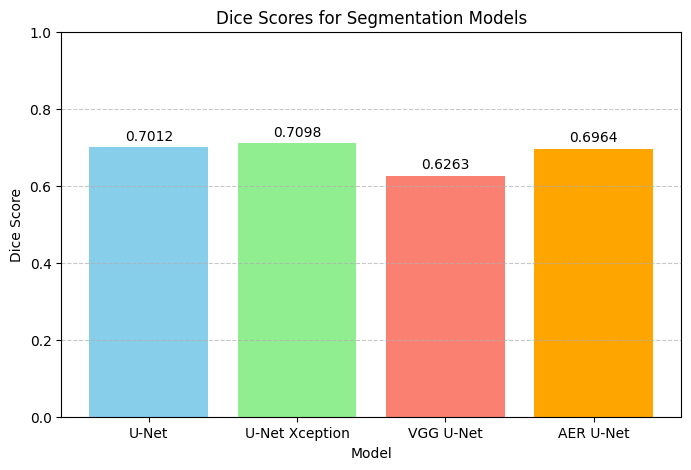

In [2]:
import matplotlib.pyplot as plt

# Dice scores for each models
dice_scores = {
    "U-Net": 0.7012,
    "U-Net Xception": 0.7098,
    "VGG U-Net": 0.6263,
    "AER U-Net": 0.6964
}


models = list(dice_scores.keys())
scores = list(dice_scores.values())

# Create bar plot
plt.figure(figsize=(8,5))
bars = plt.bar(models, scores, color=['skyblue', 'lightgreen', 'salmon', 'orange'])

for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{score:.4f}", ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1)
plt.title("Dice Scores for Segmentation Models")
plt.ylabel("Dice Score")
plt.xlabel("Model")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Inferred num_classes: 9


/tmp/ipykernel_36/2684449265.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_mask = plt.cm.get_cmap('viridis', num_classes) # Use get_cmap with num_classes


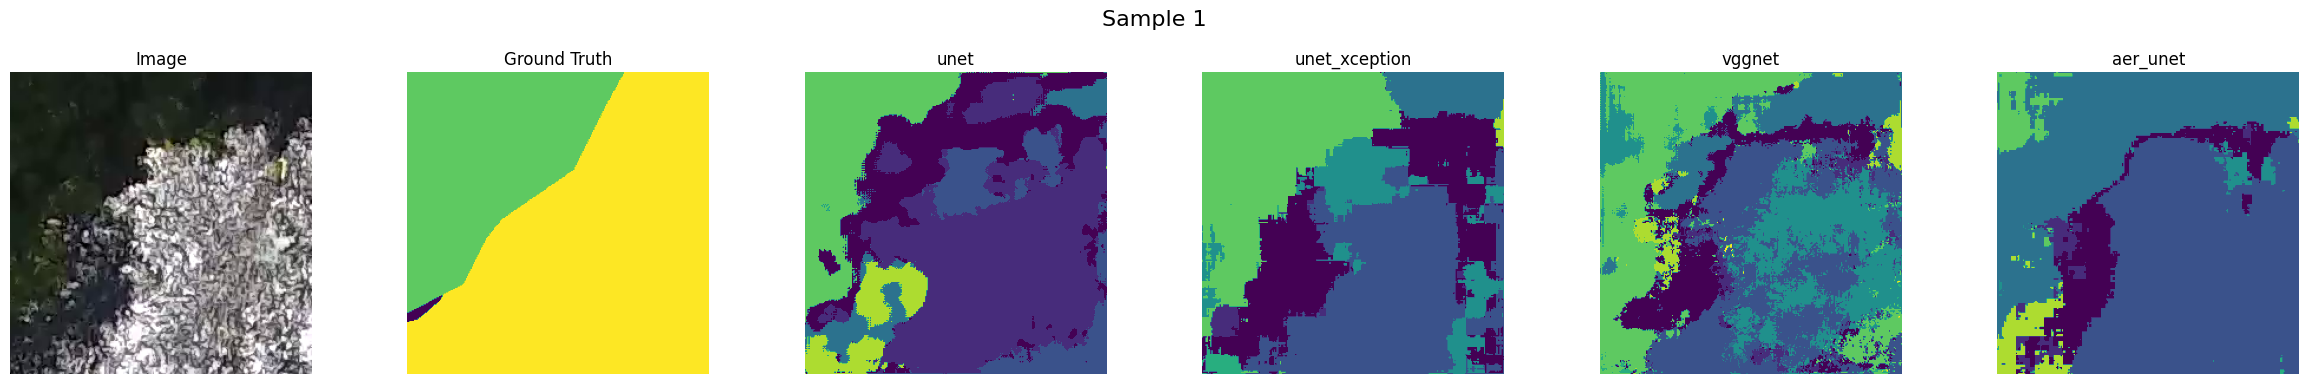

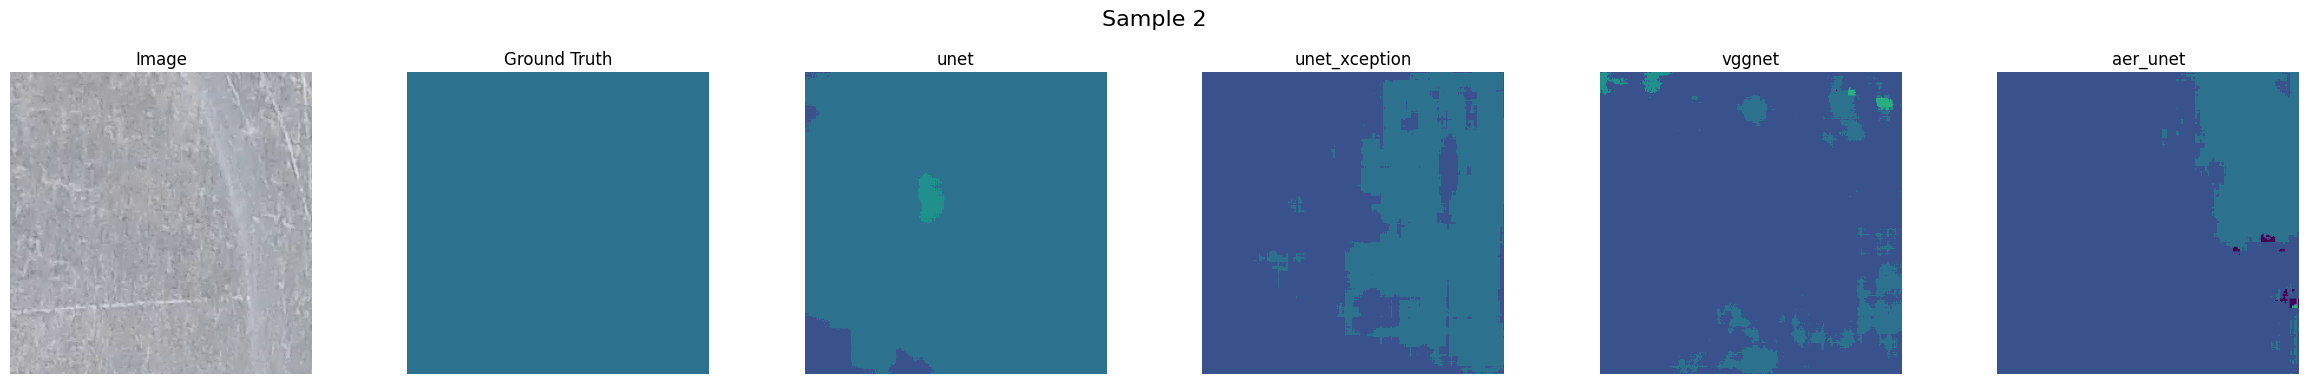

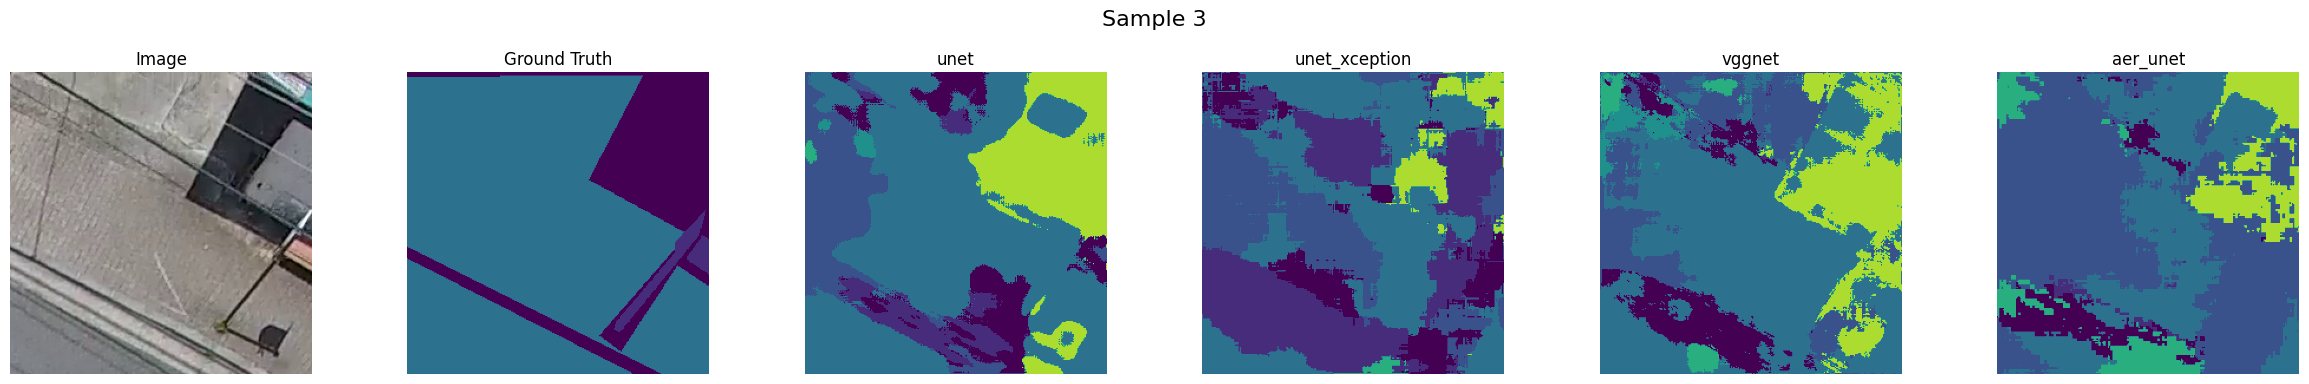

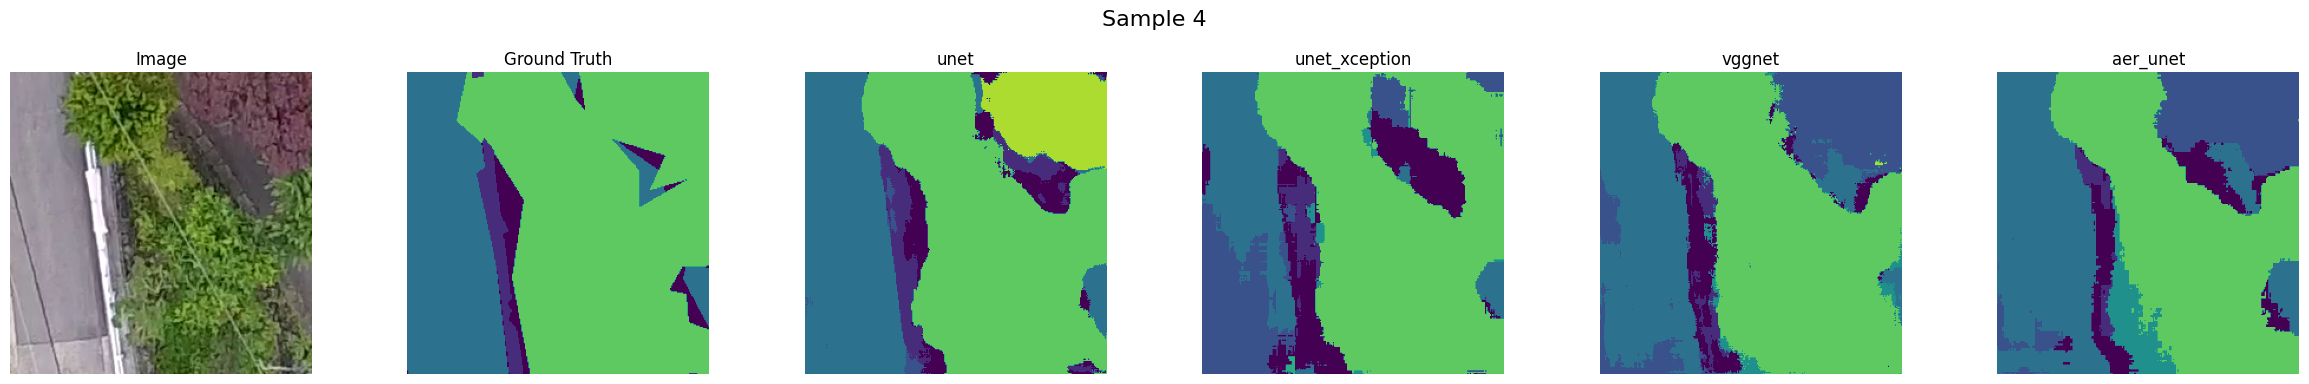

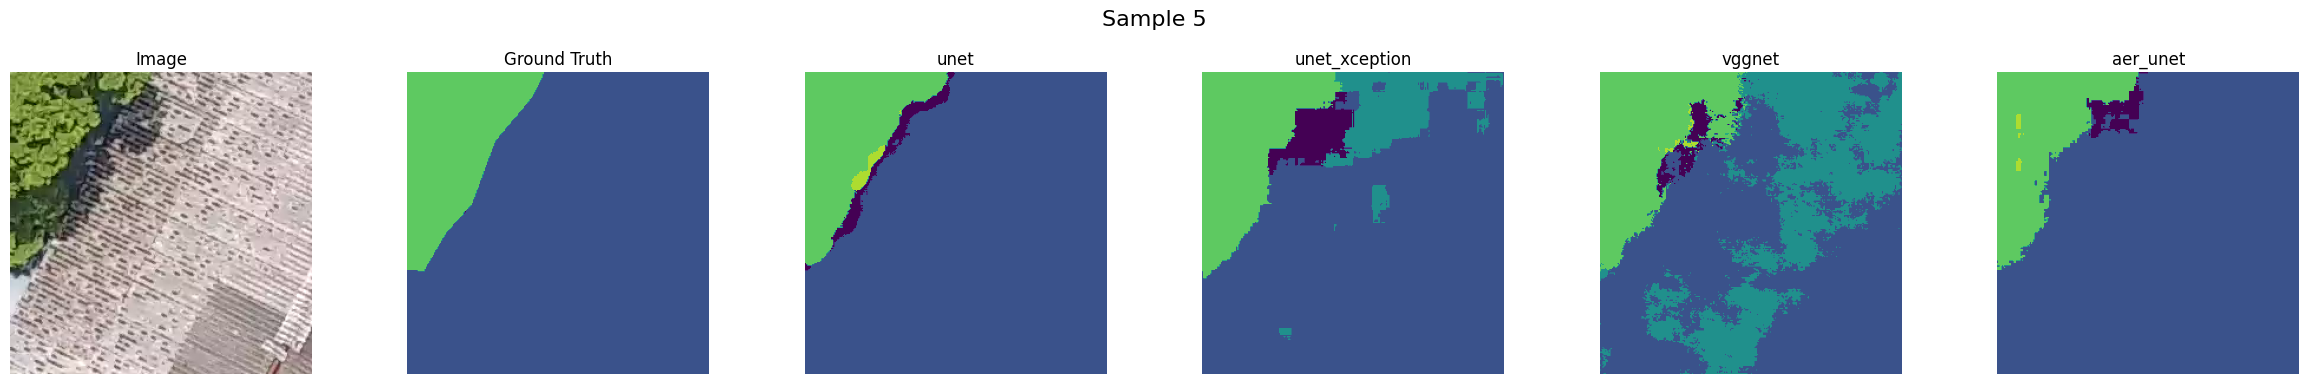

In [33]:
visualize_model_comparisons(visualization_samples, list(models.keys()))

# **Conclusion**

In this project, we conducted experiments on aerial image segmentation using drone imagery retrieved from the Kaggle Drone Dataset. The segmentation task involved identifying 10 different classes. To make training more efficient and manageable, each image was divided into patches of size 256 × 256 pixels. This patching strategy not only facilitated memory-efficient processing but also increased the number of training samples. Both the image patches and their corresponding label masks were saved in .npy format for streamlined loading during training.
For the segmentation models, we implemented and evaluated several deep learning architectures based on relevant literature. Specifically, we explored the standard U-Net, U-Net Xception, VGG U-Net, and AER U-Net models. To assess their performance, we used the Dice coefficient as considered to be a common metric for segmentation quality. The results are summarized below:

| Model            | Dice Score |
|------------------|------------|
| U-Net | 0.7012 | 
| U-Net Xception | 0.7098 | 
| VGG U-Net | 0.6263 | 
| AER U-Net | 0.6964 | 

From the results, we observe that the U-Net Xception model achieved the highest Dice score, followed closely by the standard U-Net and AER U-Net. The VGG U-Net model showed relatively lower performance in comparison.

# **References**

1. Nawaz, A., Akram, U., Salam, A. A., Ali, A. R., Ur Rehman, A., & Zeb, J. (2021). VGG-UNET for brain tumor segmentation and ensemble model for survival prediction. 2021 International Conference on Robotics and Automation in Industry (ICRAI), 1–6. https://doi.org/10.1109/ICRAI54018.2021.9651367

2. Jonnala, N. S., Siraaj, S., Prastuti, Y., et al. (2025). AER U-Net: Attention-enhanced multi-scale residual U-Net structure for water body segmentation using Sentinel-2 satellite images. Scientific Reports, 15, 16099. https://doi.org/10.1038/s41598-025-99322-z

3. Guna, R. T. A., Rahul, K., & Sikha, O. K. (2022). U-NET Xception: A two-stage segmentation-classification model for COVID detection from lung CT scan images. In International Conference on Innovative Computing and Communications (pp. 335–343). Springer. https://doi.org/10.1007/978-3-031-19130-8_29

4. Speth, S., Gonçalves, A., Rigault, B., Suzuki, S., Bouazizi, M., Matsuo, Y., & Prendinger, H. (2022). Deep learning with RGB and thermal images onboard a drone for monitoring operations. Journal of Field Robotics, 1–29. https://doi.org/10.1002/rob.22082